In [4]:
import torch  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
print(device)

cuda


In [12]:
import pandas as pd    
import numpy as np    
import torch.nn as nn    
from sklearn.preprocessing import MinMaxScaler    
  
# Load and preprocess data    
df = pd.read_csv('resampled_cpu_usage_per_machine.csv')    
df['start_time'] = pd.to_datetime(df['start_time'])    
df.set_index('start_time', inplace=True)    
    
# Select one machine    
df = df[df['machine_id'] == df['machine_id'].values[1]]    
df = df[['maximum_cpu_usage']]    
    
# Scale data to (0, 1) for LSTM    
scaler = MinMaxScaler(feature_range=(0, 1))    
df['maximum_cpu_usage'] = scaler.fit_transform(df['maximum_cpu_usage'].values.reshape(-1,1))    
    
# Convert DataFrame to numpy array    
data = df['maximum_cpu_usage'].values    
    
# Split data into train and test sets    
train_size = int(len(data) * 0.80)    
train_data, test_data = data[:train_size], data[train_size:]   
  
# Define LSTM Autoencoder model    
class Autoencoder(nn.Module):    
    def __init__(self, input_size, hidden_size, num_layers):    
        super(Autoencoder, self).__init__()    
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)    
        self.lstm2 = nn.LSTM(hidden_size, input_size, num_layers, batch_first=True)    
    
    def forward(self, x):    
        x, _ = self.lstm1(x)  
        x, _ = self.lstm2(x)  
        return x   
    
# Set up LSTM model parameters  
seq_length_in = 144  
seq_length_out = 6  
num_epochs = 3 
learning_rate = 0.01    
input_size = 1    
hidden_size = 4  
num_layers = 1  
output_size = seq_length_out  
  
autoencoder = Autoencoder(input_size, hidden_size, num_layers).to(device)  
    
# Set loss function and optimizer    
criterion = torch.nn.MSELoss()    # mean-squared error for regression    
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)    
    
# Create sequences    
def create_sequences(input_data, seq_length_in, seq_length_out):    
    inout_seq = []    
    L = len(input_data)    
    for i in range(L-seq_length_in-seq_length_out):    
        train_seq = input_data[i:i+seq_length_in]    
        train_label = input_data[i+seq_length_in:i+seq_length_in+seq_length_out]    
        inout_seq.append((train_seq ,train_label))    
    return inout_seq    
    
train_inout_seq = create_sequences(train_data, seq_length_in, seq_length_out)    
    
# Train model    
autoencoder.train()  
for epoch in range(num_epochs):    
    for seq, labels in train_inout_seq:    
        seq = torch.FloatTensor(seq).view(-1, seq_length_in, input_size).to(device)  
        labels = torch.FloatTensor(seq.cpu()).view(-1, seq_length_in, input_size).to(device)  # Make labels same as input seq  
            
        optimizer.zero_grad()    
        outputs = autoencoder(seq)    
            
        loss = criterion(outputs, labels)    
        loss.backward()    
        optimizer.step()   

    train_rmse = np.sqrt(loss.item())
    train_mse = np.mean(loss.item())
    print('epoch: ', epoch, 'train RMSE: ', train_rmse, 'train MSE: ', train_mse, 'loss: ', loss.item())  
      
  
# Calculate the reconstruction error and find a threshold  
autoencoder.eval()  
train_preds = []  
errors = []  
for seq, labels in train_inout_seq:    
    seq = torch.FloatTensor(seq).view(-1, seq_length_in, input_size).to(device)  
    labels = torch.FloatTensor(seq.cpu()).view(-1, seq_length_in, input_size).to(device)  # Make labels same as input seq  
    outputs = autoencoder(seq)  
    error = criterion(outputs, labels)  
    train_preds.append(outputs.cpu().detach().numpy())  
    errors.append(error.item())  
  
  
# Convert to numpy arrays for easier manipulation  
train_preds = np.array(train_preds)  
errors = np.array(errors)  
  
# Calculate the threshold for anomaly detection  
threshold = np.mean(errors) + 2 * np.std(errors)  # This is just an example, adjust as needed  
  
# Finally, detect anomalies  
anomalies = errors > threshold  
  
# Print anomalies  
print("Anomalies:", anomalies)  



epoch:  0 train RMSE:  0.015796504311240186 train MSE:  0.0002495295484550297 loss:  0.0002495295484550297
epoch:  1 train RMSE:  0.013227472532195852 train MSE:  0.00017496602958999574 loss:  0.00017496602958999574
epoch:  2 train RMSE:  0.011201231542883992 train MSE:  0.0001254675880772993 loss:  0.0001254675880772993
Anomalies: [False False False ...  True  True  True]


In [11]:
import matplotlib.pyplot as plt  

# Create empty arrays of NaNs  
train_predictions = np.empty_like(data)  
train_predictions[:] = np.nan  
test_predictions = np.empty_like(data)  
test_predictions[:] = np.nan  
  
# Generate predictions  
autoencoder.eval()  
with torch.no_grad():  
    for i, (seq, labels) in enumerate(train_inout_seq):  
        seq = torch.FloatTensor(seq).view(-1, seq_length_in, input_size).to(device)  
        train_pred = autoencoder(seq)  
        train_predictions[i+seq_length_in : i+seq_length_in+seq_length_out] = train_pred.cpu().numpy().flatten()  
  
    for i, (seq, labels) in enumerate(test_inout_seq):  
        seq = torch.FloatTensor(seq).view(-1, seq_length_in, input_size).to(device)  
        test_pred = autoencoder(seq)  
        test_predictions[i+train_size+seq_length_in : i+train_size+seq_length_in+seq_length_out] = test_pred.cpu().numpy().flatten()  

train_predictions = scaler.inverse_transform(train_predictions.reshape(-1, 1))  
test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1))  
data = scaler.inverse_transform(data.reshape(-1, 1))  
  
# Plotting  
plt.figure(figsize=(14, 7))  
  
# Original data  
plt.plot(range(len(data)), data, label='Original data')  
  
# Train predictions  
plt.plot(range(len(data)), train_predictions, label='Train Predictions')  
  
# Test predictions  
plt.plot(range(len(data)), test_predictions, label='Test Predictions')  
  
plt.title('Train Predictions and Test Predictions')  
plt.xlabel('Index')  
plt.ylabel('Maximum CPU Usage')  
plt.legend()  
plt.show()  


ValueError: could not broadcast input array from shape (144,) into shape (6,)

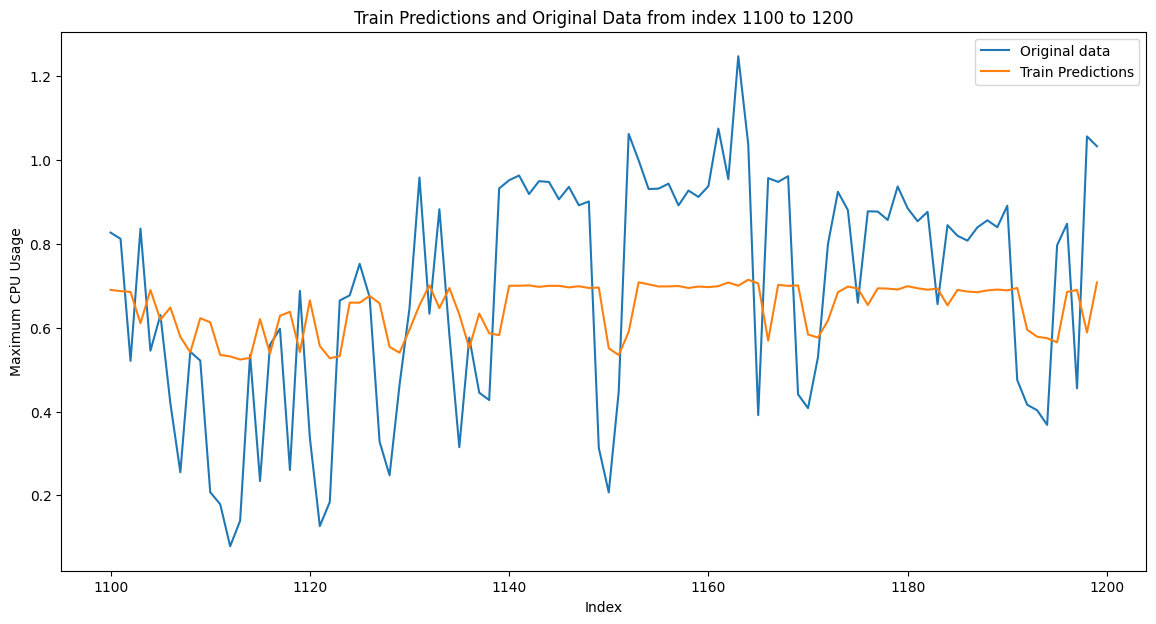

In [6]:
# Define the range of interest  
start_index = 1100  
end_index = 1200  
  
# Plotting  
plt.figure(figsize=(14, 7))  
  
# Original data  
plt.plot(range(start_index, end_index), data[start_index:end_index], label='Original data')  
  
# Train predictions  
plt.plot(range(start_index, end_index), train_predictions[start_index:end_index], label='Train Predictions')  
  
plt.title('Train Predictions and Original Data from index 1100 to 1200')  
plt.xlabel('Index')  
plt.ylabel('Maximum CPU Usage')  
plt.legend()  
plt.show()  


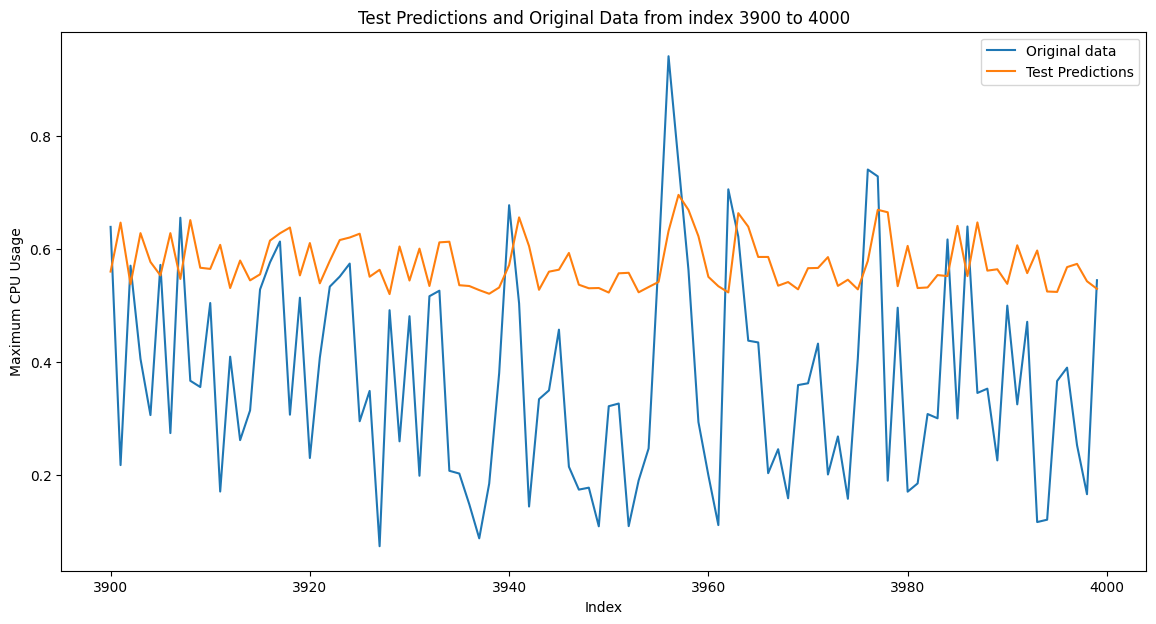

In [8]:
# Define the range of interest  
start_index = 3900  
end_index = 4000  
  
# Plotting  
plt.figure(figsize=(14, 7))  
  
# Original data  
plt.plot(range(start_index, end_index), data[start_index:end_index], label='Original data')  
  
# Test predictions  
plt.plot(range(start_index, end_index), test_predictions[start_index:end_index], label='Test Predictions')  
  
plt.title('Test Predictions and Original Data from index 3900 to 4000')  
plt.xlabel('Index')  
plt.ylabel('Maximum CPU Usage')  
plt.legend()  
plt.show()  
